# AVERAGE PRECISION 

In [1]:
import sys
import numpy as np
from datetime import datetime
import pandas as pd
import argparse
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import sklearn
sys.path.append('../')
from utils import *
#from utils.feature_selection import *
from plot import *
from simulation_setup import *
from models import *
from models.forests import *
from models.Extended_IF import *
from models.Extended_DIFFI import *
from models.Extended_DIFFI_original import *
from sklearn.ensemble import IsolationForest,RandomForestClassifier
from sklearn.metrics import classification_report,average_precision_score,roc_auc_score
import math
import seaborn as sns
sns.set()

import os
import pickle 
import scipy.io

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

## Average Precision Functions 

In [2]:
def evaluate_precisions(X_train,X_test,y,name):
    EIF=ExtendedIF(n_trees=300,plus=0)
    EIF.fit(X_train)
    EIF=ExtendedIF(n_trees=300,plus=1)
    EIF_plus.fit(X_train)
    iforest = IsolationForest(n_estimators=300,max_samples=256)
    iforest.fit(X_train)
    score = EIF.predict(X_test)
    precision_EIF = average_precision_score(y,score)
    score_plus = EIF_plus.predict(X_test)
    precision_EIF_plus = average_precision_score(y,score_plus)
    scoreif = -1*iforest.score_samples(X_test)+0.5
    precision_IF = average_precision_score(y,scoreif)

    d={
    'score':[score,score_plus,scoreif],
    'average_precision':[precision_EIF,precision_EIF_plus,precision_IF],
    'contamination':sum(y)/len(y),'real label': y
    }

    pwd='c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI'
    path=pwd+'\\results\\davide\\info_violin\\info_violin_'+str(name) + '_split.pkl'
    with open(path, 'wb') as f:
        pickle.dump(d,f)
    
    return precision_IF,precision_EIF,precision_EIF_plus

In [4]:
def collect_precisions(Precisions_scores,name,X_train,X_test,y):
    Precisions_scores[name]={}
    Precisions_scores[name]['IF']=[]
    Precisions_scores[name]['EIF']=[]
    Precisions_scores[name]['EIF_plus']=[]
    for i in tqdm(range(10)):
        precision_IF,precision_EIF,precision_EIF_plus = evaluate_precisions(X_train,X_test,y,name)
        Precisions_scores[name]['IF'].append(precision_IF)
        Precisions_scores[name]['EIF'].append(precision_EIF)
        Precisions_scores[name]['EIF_plus'].append(precision_EIF_plus)
    return Precisions_scores

# Synthetic Datasets 

## Load pkl files 

In [6]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data'

In [8]:
file_to_read = open(os.getcwd()+'\\anomalies.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)
X_xaxis,X_yaxis,X_bisect,X_bisect_3d,X_bisect_6d=loaded_dictionary['X_xaxis'],loaded_dictionary['X_yaxis'],loaded_dictionary['X_bisec'],loaded_dictionary['X_bisec_3d'],loaded_dictionary['X_bisec_6d']

# Precisions Score Automatic Computation Function

## Synthetic Datasets

In [9]:
def precisions_scores_synt(name,X_train,X_test,Precisions_scores,Precisions_scores_split):
    
    X=np.r_[X_train,X_test]
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    y_train=np.zeros(X_train.shape[0])
    y_test=np.ones(X_test.shape[0])
    y=np.concatenate([y_train,y_test])
    X_test=np.r_[X_train,X_test]
    scaler2=StandardScaler()
    #X=scaler2.fit_transform(X)

    # Compute precision scores without split
    Precisions_scores=collect_precisions(Precisions_scores,name,X_test,X_test,y)
    # Compute precision scores with split
    Precisions_scores_split=collect_precisions(Precisions_scores_split,name,X_train,X_test,y)

    print('--------------------------------------------------------')
    print(name)
    print()
    print('Precision Scores no train test split ')
    print('IF -> ' + str(np.mean(Precisions_scores[name]['IF'])))
    print('EIF -> ' + str(np.mean(Precisions_scores[name]['EIF'])))
    print('EIF_plus -> ' + str(np.mean(Precisions_scores[name]['EIF_plus'])))
    print(' ')
     
    print('Precision Scores with train test split ')
    print('IF -> ' + str(np.mean(Precisions_scores_split[name]['IF'])))
    print('EIF -> ' + str(np.mean(Precisions_scores_split[name]['EIF'])))
    print('EIF_plus -> ' + str(np.mean(Precisions_scores_split[name]['EIF_plus'])))
    print('-----------------------------------------------------------')
    

    #return Precisions_scores
    return Precisions_scores,Precisions_scores_split


## Real World Datasets

In [21]:
def precisions_scores(name,Precisions_scores,Precisions_scores_split):

    if name=='diabetes' or name=='moodify':
        X,y=csv_dataset(name,os.getcwd()+'\\')
    else:
        X,y=dataset(name,os.getcwd()+'\\')
    
    X,y=downsample(X,y)
    X_train,X_test=partition_data(X,y)
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    y_train=np.zeros(X_train.shape[0])
    y_test=np.ones(X_test.shape[0])
    y2=np.concatenate([y_train,y_test])
    X_test=np.r_[X_train,X_test]
    scaler2=StandardScaler()
    X=scaler2.fit_transform(X)

    Precisions_scores = collect_precisions(Precisions_scores,name,X,X,y)
    Precisions_scores_split = collect_precisions(Precisions_scores_split,name,X_train,X_test,y2)

    print('--------------------------------------------------------')
    print(name)
    print()
    
    print('Precision Scores no train test split ')
    print('IF -> ' + str(np.mean(Precisions_scores[name]['IF'])))
    print('EIF -> ' + str(np.mean(Precisions_scores[name]['EIF'])))
    print('EIF_plus -> ' + str(np.mean(Precisions_scores[name]['EIF_plus'])))
    print(' ')
    
    print('Precision Scores with train test split ')
    print('IF -> ' + str(np.mean(Precisions_scores_split[name]['IF'])))
    print('EIF -> ' + str(np.mean(Precisions_scores_split[name]['EIF'])))
    print('EIF_plus -> ' + str(np.mean(Precisions_scores_split[name]['EIF_plus'])))
    print('-----------------------------------------------------------')
    
    #return Precisions_scores_split
    return Precisions_scores,Precisions_scores_split


In [10]:
Precisions_scores={}
Precisions_scores_split={}

In [20]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')

In [ ]:
dataset_names=['wine','annthyroid','breastw','shuttle','pima','cardio','glass',
             'ionosphere','pendigits','diabetes','moodify']
for name in dataset_names:
    Precisions_scores,Precisions_scores_split=precisions_scores(name,Precisions_scores,Precisions_scores_split)

## Synthetic Dataset

In [12]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data')
os.getcwd()

'c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data\\diffi_data'

Re Load every time the Training Set to avoid to scale it multiple times

In [13]:
file_to_read = open(os.getcwd()+'\\ball_6_dim.pkl', "rb")
loaded_dictionary = pickle.load(file_to_read)

In [ ]:
Precisions_scores,Precisions_scores_split=precisions_scores_synt('X_xaxis',X_train,X_xaxis,Precisions_scores,Precisions_scores_split)
X_train=loaded_dictionary['X_train']
Precisions_scores,Precisions_scores_split=precisions_scores_synt('X_yaxis',X_train,X_yaxis,Precisions_scores,Precisions_scores_split)
X_train=loaded_dictionary['X_train']
Precisions_scores,Precisions_scores_split=precisions_scores_synt('X_bisect',X_train,X_bisect,Precisions_scores,Precisions_scores_split)
X_train=loaded_dictionary['X_train']
Precisions_scores,Precisions_scores_split=precisions_scores_synt('X_bisect_3d',X_train,X_bisect_3d,Precisions_scores,Precisions_scores_split)
X_train=loaded_dictionary['X_train']
Precisions_scores,Precisions_scores_split=precisions_scores_synt('X_bisect_6d',X_train,X_bisect_6d,Precisions_scores,Precisions_scores_split)

## Load the results in a pkl file 

In [26]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')

### Write in the pkl file 

In [28]:
path = os.getcwd() + '\\results\\davide\\Performance Report\\Precisions_scores_no_split_right.pkl'
with open(path, 'wb') as f:
    pickle.dump(Precisions_scores,f)

In [70]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI')
path = os.getcwd() + '//results//davide//Performance Report//Precisions_scores_plus_new.pkl'
with open(path, 'wb') as f:
    pickle.dump(Precisions_scores, f)

### Read from the pkl file 

In [3]:
path = os.getcwd() + '\\results\\davide\\Performance Report\\Precisions_scores_no_split.pkl'
with open(path, 'rb') as f:
    Prec_score= pickle.load(f)

In [7]:
path = os.getcwd() + '\\results\\davide\\Performance Report\\Precisions_scores_plus_new.pkl'
with open(path, 'rb') as f:
    Precisions_scores = pickle.load(f)

# Violin Plot

In [34]:
import matplotlib.patches as mpatches
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

Without split

In [36]:
os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\results\\davide')
data = []

dataset_names=['X_xaxis','X_yaxis','X_bisect','X_bisect_3d','X_bisect_6d',
                        'wine','annthyroid','breastw','shuttle','pima','cardio','glass',
                            'ionosphere','pendigits','diabetes','moodify']

'''
for key in dataset_names_synt:     
    for algorithm in ['IF',"EIF","EIF_plus"]:
        data.append(Precisions_scores_split[key][algorithm])
'''

for key in dataset_names:     
    for algorithm in ['IF',"EIF","EIF_plus"]:
        data.append(Prec_score[key][algorithm])
    
for i in range(len(data)):
    data[i] = [float(x) for x in data[i]]

In [37]:
dataset_names_complete=['X_xaxis','X_yaxis','X_bisect','X_bisect_3d','X_bisect_6d',
                        'wine','annthyroid','breastw','shuttle','pima','cardio','glass',
                            'ionosphere','pendigits','diabetes','moodify']

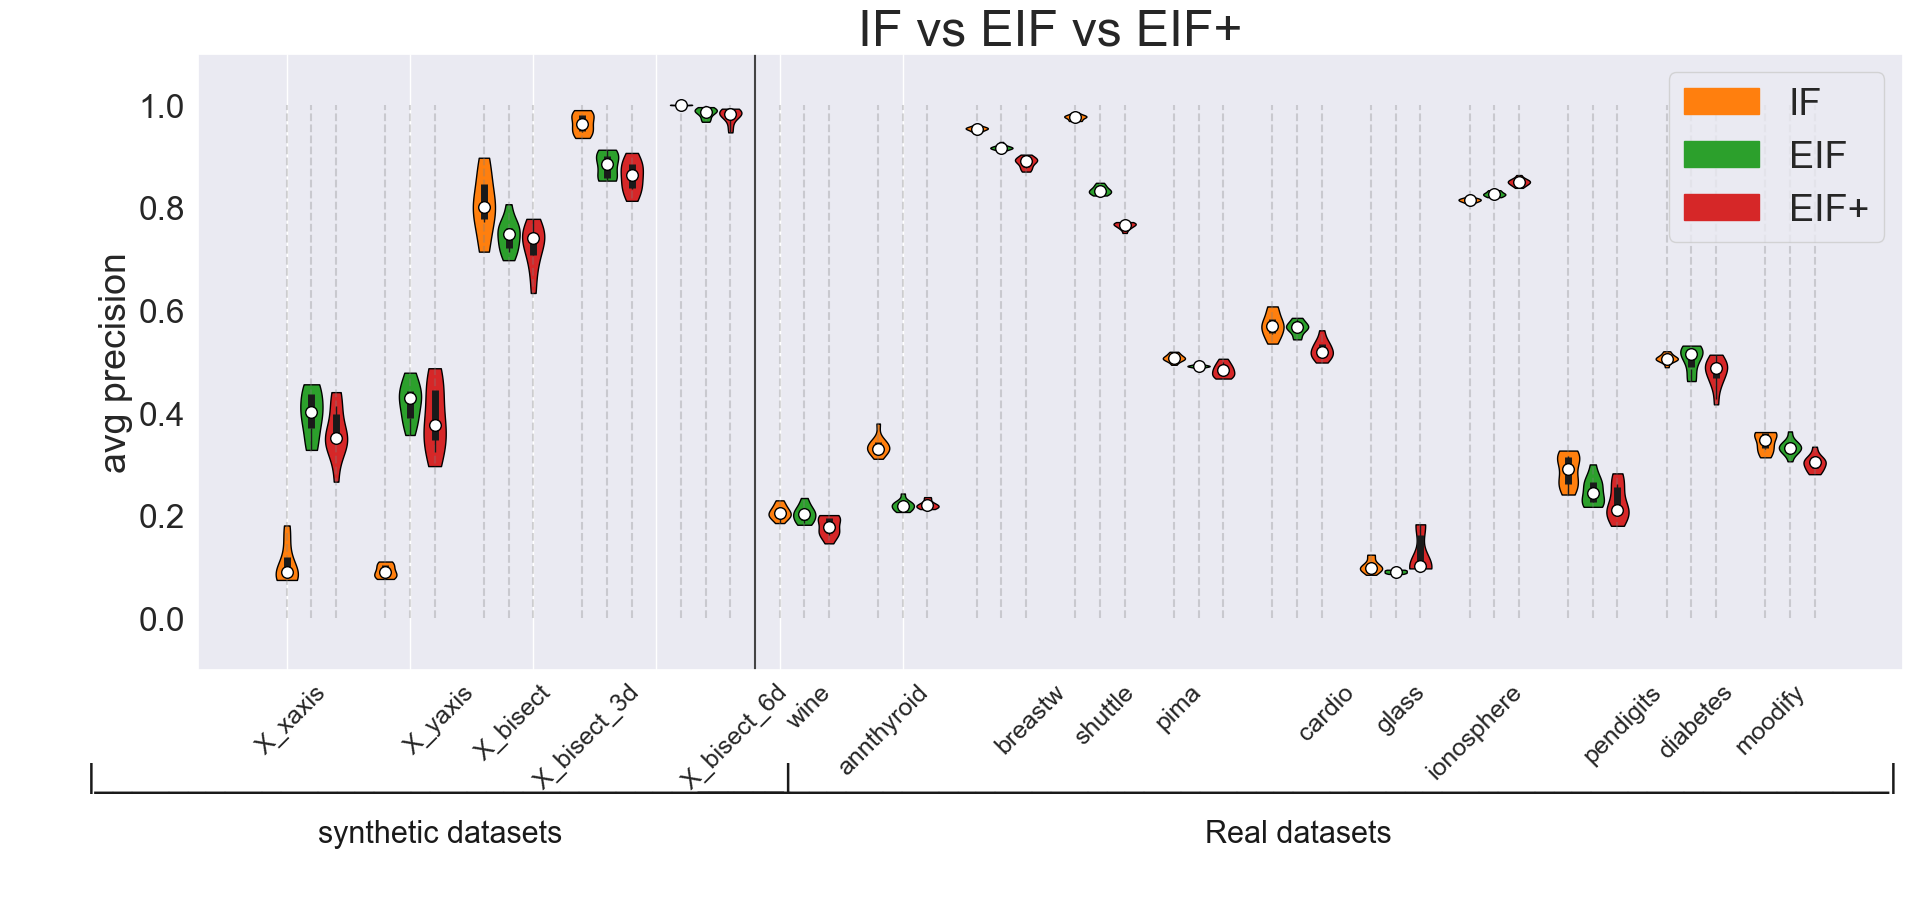

In [38]:
from matplotlib.lines import Line2D
plt.figure(figsize=(22, 8))  

parts = plt.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False,widths = 0.9,positions=[x+(x//3) for x in range(len(data))])


for n,pc in enumerate(parts['bodies']):
        if n%3==0:
                pc.set_facecolor('tab:orange')
        elif n%3==1:
                pc.set_facecolor('tab:green')
        else:
                pc.set_facecolor('tab:red')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

inds = [x+(x//3) for x in range(len(data))]


for i in inds:
        plt.plot([i,i],[0,1],'--',c="tab:gray",alpha = 0.3)

plt.plot([19,19],[-0.5,1.5],c="k",alpha = 0.8)

quartile1, medians, quartile3 = np.percentile(np.array(data), [25, 50, 75], axis=1)

whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

plt.scatter(inds, medians, marker='o', color='white',edgecolors="black", s=70, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
plt.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

plt.grid(axis = "y")
plt.title('IF vs EIF vs EIF+',fontsize = 36)
plt.ylim(-0.1,1.1)

plt.xticks([x+0.2 for x in inds if x%3==0],dataset_names_complete,minor = True,fontsize=18,rotation = 45)
plt.xticks(range(0,30,5),[""]*len(range(0,30,5)))
plt.yticks(fontsize=24)
plt.xlabel("\n \n ",fontsize=27)
plt.ylabel("avg precision",fontsize=27)

plt.annotate('|_____________________________________|', xy=(.200, 0.18), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=24, color='k')
plt.annotate('synthetic datasets', xy=(.200, 0.11), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=22, color='k')
plt.annotate('________________________________________________________________|', xy=(.59, 0.18), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=24, color='k')
plt.annotate('Real datasets', xy=(.59, 0.11), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=22, color='k')

orange_patch = mpatches.Patch(color='tab:orange', label='IF')
green_patch = mpatches.Patch(color='tab:green', label='EIF')
red_patch = mpatches.Patch(color='tab:red', label='EIF+')
plt.legend(handles=[orange_patch,green_patch,red_patch],loc="upper right",fontsize=27)
plt.savefig(os.getcwd()+'/Violin_Plot_no_split.pdf',bbox_inches = "tight")
plt.show()


With Split

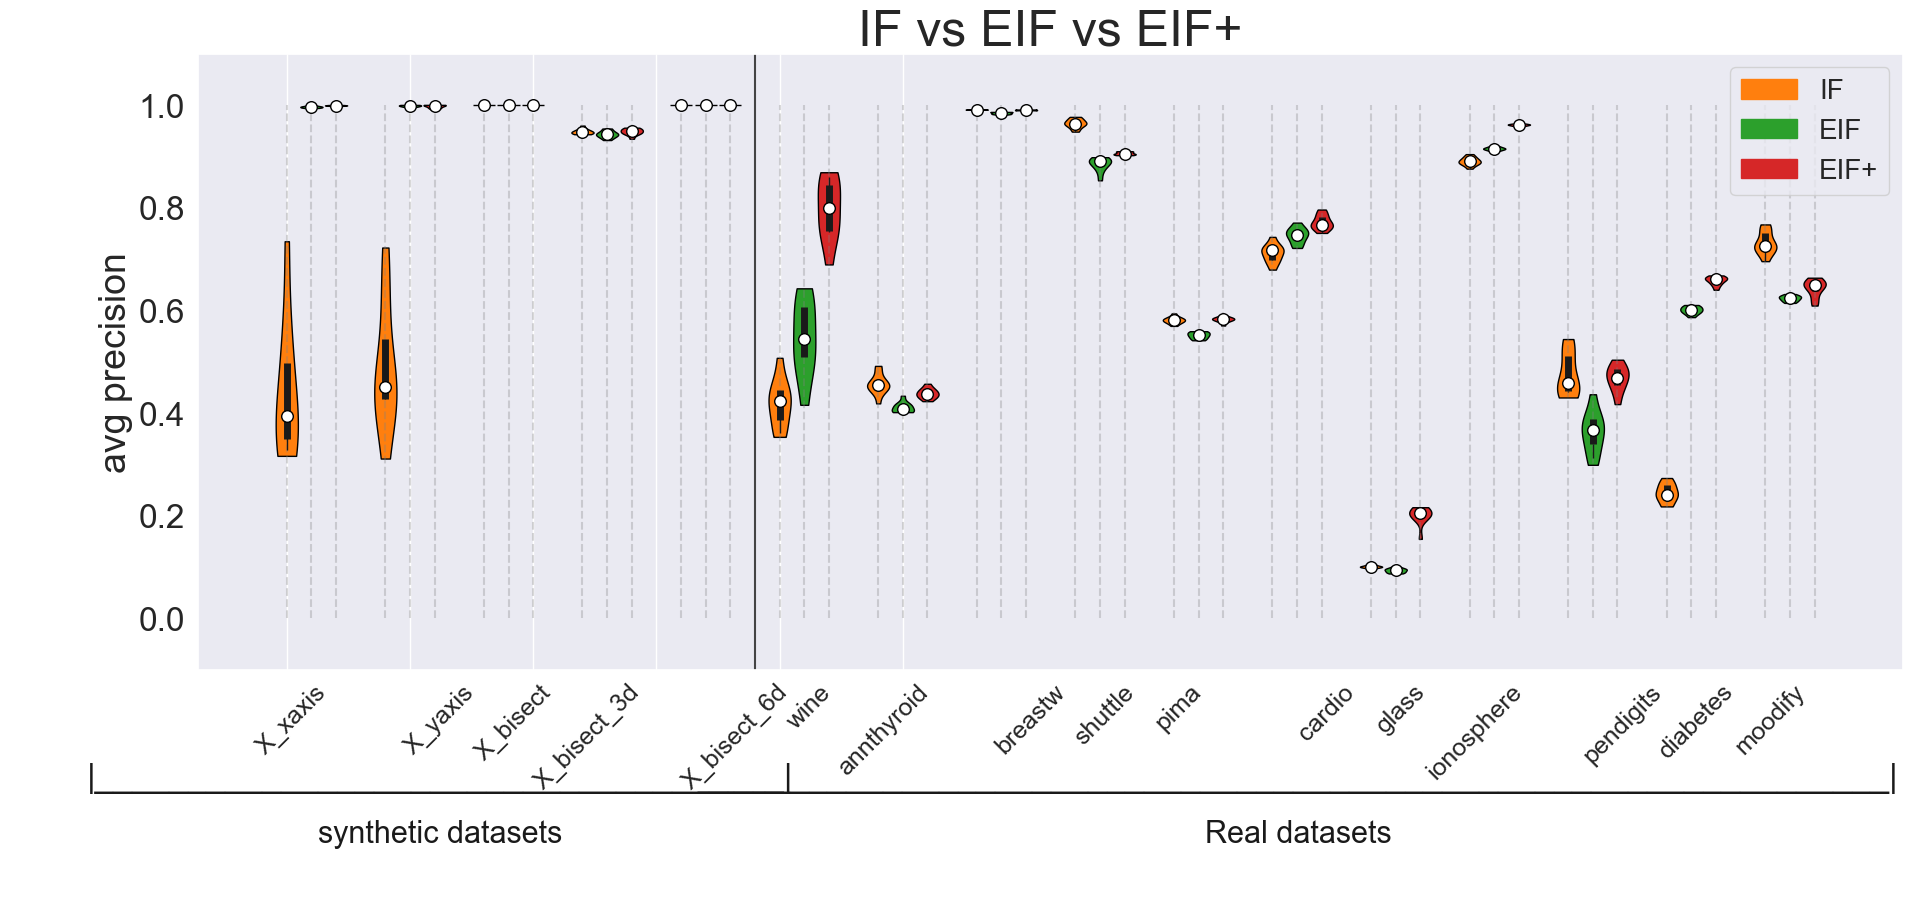

In [43]:
from matplotlib.lines import Line2D
plt.figure(figsize=(22, 8))  

parts = plt.violinplot(
        data, showmeans=False, showmedians=False,
        showextrema=False,widths = 0.9,positions=[x+(x//3) for x in range(len(data))])


for n,pc in enumerate(parts['bodies']):
        if n%3==0:
                pc.set_facecolor('tab:orange')
        elif n%3==1:
                pc.set_facecolor('tab:green')
        else:
                pc.set_facecolor('tab:red')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

inds = [x+(x//3) for x in range(len(data))]


for i in inds:
        plt.plot([i,i],[0,1],'--',c="tab:gray",alpha = 0.3)

plt.plot([19,19],[-0.5,1.5],c="k",alpha = 0.8)

quartile1, medians, quartile3 = np.percentile(np.array(data), [25, 50, 75], axis=1)

whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

plt.scatter(inds, medians, marker='o', color='white',edgecolors="black", s=70, zorder=3)
plt.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
plt.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

plt.grid(axis = "y")
plt.title('IF vs EIF vs EIF+',fontsize = 36)
plt.ylim(-0.1,1.1)

plt.xticks([x+0.2 for x in inds if x%3==0],dataset_names_complete,minor = True,fontsize=18,rotation = 45)
plt.xticks(range(0,30,5),[""]*len(range(0,30,5)))
plt.yticks(fontsize=24)
plt.xlabel("\n \n ",fontsize=27)
plt.ylabel("avg precision",fontsize=27)

plt.annotate('|_____________________________________|', xy=(.200, 0.18), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=24, color='k')
plt.annotate('synthetic datasets', xy=(.200, 0.11), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=22, color='k')
plt.annotate('________________________________________________________________|', xy=(.59, 0.18), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=24, color='k')
plt.annotate('Real datasets', xy=(.59, 0.11), rotation=0, xycoords='figure fraction',
            horizontalalignment='center', verticalalignment='center', fontsize=22, color='k')

orange_patch = mpatches.Patch(color='tab:orange', label='IF')
green_patch = mpatches.Patch(color='tab:green', label='EIF')
red_patch = mpatches.Patch(color='tab:red', label='EIF+')
plt.legend(handles=[orange_patch,green_patch,red_patch],loc="upper right",fontsize=20)
plt.savefig(os.getcwd()+'/Violin_Plot_with_split_new.pdf',bbox_inches = "tight")
plt.show()


## RANDOM FOREST FEATURE IMPORTANCE 

Compute the order of importance according to the Random Forest model for the datasets that are not included in the dictionary with the hard-coded Importance order that is placed in feture_selection.py in the function Random_Forest_Feature_importance.

The dataset missing the RF Feature Importance are: diabetes,moodify, and glass

In [16]:
def csv_dataset(name, path = "../data/"):
    datapath = path + name + ".csv"
    data=pd.read_csv(datapath,index_col=0)
    if 'Unnamed: 0' in data.columns:
        data=data.drop(columns=['Unnamed: 0'])
    
    X=data[data.columns[data.columns!='Target']]
    y=data['Target']
    
    X,y = drop_duplicates(X,y)
    print(name, "\n")
    print_dataset_resume(X,y)
    
    return X,y

In [17]:
def compute_rf_feat_imp(name):

    os.chdir('c:\\Users\\lemeda98\\Desktop\\PHD Information Engineering\\ExIFFI\\ExIFFI\\data')
    if name=='diabetes' or name=='moodify':
        X,y=csv_dataset(name,os.getcwd()+'\\')
    else:
        X,y=dataset(name,os.getcwd()+'\\')

    X,y=downsample(X,y)
    X_train,X_test=partition_data(X,y)
    scaler=StandardScaler()
    X=np.r_[X_train,X_test]
    X=scaler.fit_transform(X)
    y_train=np.zeros(X_train.shape[0])
    y_test=np.ones(X_test.shape[0])
    y=np.concatenate([y_train,y_test])

    RF=RandomForestClassifier(n_estimators=200)
    RF.fit(X,y)

    return RF.feature_importances_.argsort()[::-1]



In [ ]:
Random_Forest_feat_imp={}
dataset_names=['wine','annthyroid','breastw','shuttle','pima','cardio','glass',
             'ionosphere','pendigits','diabetes','moodify']
for name in dataset_names:
    Random_Forest_feat_imp[name]=compute_rf_feat_imp(name)